In [0]:
#Assume my aunt and uncle immigrated to Canada from China rescently because of their son, daughter and some other relatives is working and living in Toronto
#They can speak basic English and they are at their 50s, so they want to open a chinese restaurant to make a living on their own
#The problem we want to slove here is where do we recommend the chinese restaurant be open
#We konw their son is working in Downtown Toronto, they want to stay close to their son and daughter


In [1]:
#First lets do some exploratory analysis of downtown Toronto's neighbours by using K-means Clustering
#Import all the necessary libraries
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
!pip -q install geopy
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip -q install folium
import folium
print('Libraries imported.')

Libraries imported.


In [2]:
#get the Borough and Neighbourhood from Wiki and do some data wrangling
df=pd.read_html("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.")[0]
df.replace("Not assigned", np.nan, inplace = True)
df.dropna(subset=["Borough"], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [3]:
#add the geographic coordinates
path='http://cocl.us/Geospatial_data'
df1 = pd.read_csv(path)
df1.rename(columns={"Postal Code": "Postcode"}, inplace=True)
toronto_df = df.merge(df1, on="Postcode", how="left")
toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


In [4]:
#as my uncle and aunt only want to stay close to their son and daughter, so we only working on Downtown Borough
downtown_df = toronto_df[toronto_df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
address = 'Downtown Toronto, TO'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))
#drow the map of downtown Toronto
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, label in zip(downtown_df['Latitude'], downtown_df['Longitude'], downtown_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


In [5]:
#use the data from Foursquare to do the K-means Clustering
CLIENT_ID = 'QNKC1QSMEN4YGAO2WGBYPS4PESKOM3ZGN45FO1UZRYHRA2YN' 
CLIENT_SECRET = '05MR0UPVLLRJCX1NLGFCT1VSWSJVBMPL0TZQSDD0BH534QLF' 
VERSION = '20180605' 
LIMIT=100
radius=500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


downtown_venues = getNearbyVenues(names=downtown_df['Neighbourhood'],
                                   latitudes=downtown_df['Latitude'],
                                   longitudes=downtown_df['Longitude']
                                  )

Harbourfront
Queen's Park
Ryerson
Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Harbourfront East
Toronto Islands
Union Station
Design Exchange
Toronto Dominion Centre
Commerce Court
Victoria Hotel
Harbord
University of Toronto
Chinatown
Grange Park
Kensington Market
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city
Church and Wellesley


In [6]:
print(downtown_venues.shape)
downtown_venues.head()

(2472, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [7]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")
downtown_onehot['Neighbourhood'] = downtown_venues['Neighbourhood'] 
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]
downtown_grouped = downtown_onehot.groupby('Neighbourhood').mean().reset_index()
downtown_grouped

num_top_venues = 5
for hood in downtown_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = downtown_grouped['Neighbourhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

----Adelaide----
             venue  freq
0      Coffee Shop  0.07
1       Restaurant  0.05
2             Café  0.04
3  Thai Restaurant  0.04
4       Steakhouse  0.03
----Bathurst Quay----
                venue  freq
0     Airport Service  0.18
1      Airport Lounge  0.12
2    Airport Terminal  0.12
3    Sculpture Garden  0.06
4  Airport Food Court  0.06
----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.04
2      Beer Bar  0.04
3    Restaurant  0.04
4   Cheese Shop  0.04
----CN Tower----
                venue  freq
0     Airport Service  0.18
1      Airport Lounge  0.12
2    Airport Terminal  0.12
3    Sculpture Garden  0.06
4  Airport Food Court  0.06
----Cabbagetown----
         venue  freq
0         Café  0.07
1  Coffee Shop  0.07
2   Restaurant  0.05
3         Park  0.05
4  Pizza Place  0.05
----Central Bay Street----
                venue  freq
0         Coffee Shop  0.16
1  Italian Restaurant  0.05
2      Sandwich Place  0.05
3      Ice Cream Shop

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Restaurant,Café,Thai Restaurant,Bar,Steakhouse,Bakery,Concert Hall,Bookstore,Breakfast Spot
1,Bathurst Quay,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
2,Berczy Park,Coffee Shop,Cheese Shop,Seafood Restaurant,Restaurant,Café,Bakery,Cocktail Bar,Beer Bar,Farmers Market,Eastern European Restaurant
3,CN Tower,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
4,Cabbagetown,Coffee Shop,Café,Italian Restaurant,Bakery,Park,Restaurant,Pizza Place,Pub,Caribbean Restaurant,Diner


In [8]:
kclusters = 7
downtown_grouped_clustering = downtown_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)
kmeans.labels_[0:10] 
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
downtown_merged = downtown_df
downtown_merged = downtown_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
downtown_merged.head() 

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Café,Theater,Restaurant,Breakfast Spot,Farmers Market
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,1,Coffee Shop,Yoga Studio,Seafood Restaurant,Hobby Shop,Creperie,Bank,Bar,Café,Beer Bar,Diner
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937,3,Coffee Shop,Clothing Store,Japanese Restaurant,Café,Middle Eastern Restaurant,Cosmetics Shop,Restaurant,Lingerie Store,Bubble Tea Shop,Bookstore
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,3,Coffee Shop,Clothing Store,Japanese Restaurant,Café,Middle Eastern Restaurant,Cosmetics Shop,Restaurant,Lingerie Store,Bubble Tea Shop,Bookstore
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Coffee Shop,Café,Restaurant,Italian Restaurant,Bakery,Diner,Breakfast Spot,Park,Hotel,Japanese Restaurant


In [9]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Neighbourhood'], downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [10]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 0, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Downtown Toronto,0,Café,Restaurant,Bar,Italian Restaurant,Japanese Restaurant,Bakery,Bookstore,Sandwich Place,Beer Bar,Beer Store
19,Downtown Toronto,0,Café,Restaurant,Bar,Italian Restaurant,Japanese Restaurant,Bakery,Bookstore,Sandwich Place,Beer Bar,Beer Store


In [0]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 1, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
24,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
25,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
26,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
27,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
28,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
29,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop


In [11]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 2, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Downtown Toronto,2,Park,Playground,Trail,Creperie,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner


In [12]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 3, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,3,Coffee Shop,Clothing Store,Japanese Restaurant,Café,Middle Eastern Restaurant,Cosmetics Shop,Restaurant,Lingerie Store,Bubble Tea Shop,Bookstore
3,Downtown Toronto,3,Coffee Shop,Clothing Store,Japanese Restaurant,Café,Middle Eastern Restaurant,Cosmetics Shop,Restaurant,Lingerie Store,Bubble Tea Shop,Bookstore
4,Downtown Toronto,3,Coffee Shop,Café,Restaurant,Italian Restaurant,Bakery,Diner,Breakfast Spot,Park,Hotel,Japanese Restaurant
5,Downtown Toronto,3,Coffee Shop,Cheese Shop,Seafood Restaurant,Restaurant,Café,Bakery,Cocktail Bar,Beer Bar,Farmers Market,Eastern European Restaurant
8,Downtown Toronto,3,Coffee Shop,Restaurant,Café,Thai Restaurant,Bar,Steakhouse,Bakery,Concert Hall,Bookstore,Breakfast Spot
9,Downtown Toronto,3,Coffee Shop,Restaurant,Café,Thai Restaurant,Bar,Steakhouse,Bakery,Concert Hall,Bookstore,Breakfast Spot
10,Downtown Toronto,3,Coffee Shop,Restaurant,Café,Thai Restaurant,Bar,Steakhouse,Bakery,Concert Hall,Bookstore,Breakfast Spot
14,Downtown Toronto,3,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Italian Restaurant,Bar,Gastropub,Seafood Restaurant,Japanese Restaurant
15,Downtown Toronto,3,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Italian Restaurant,Bar,Gastropub,Seafood Restaurant,Japanese Restaurant
16,Downtown Toronto,3,Coffee Shop,Restaurant,Café,Hotel,American Restaurant,Gym,Japanese Restaurant,Deli / Bodega,Seafood Restaurant,Italian Restaurant


In [13]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 4, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
24,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
25,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
26,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
27,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
28,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop
29,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Sculpture Garden,Coffee Shop


In [14]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 5, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Downtown Toronto,5,Grocery Store,Café,Park,Baby Store,Nightclub,Candy Store,Restaurant,Diner,Italian Restaurant,Coffee Shop


In [15]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 6, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Downtown Toronto,6,Bar,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Grocery Store,Chinese Restaurant
21,Downtown Toronto,6,Bar,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Grocery Store,Chinese Restaurant
22,Downtown Toronto,6,Bar,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Grocery Store,Chinese Restaurant


In [20]:
Chinese_Restaurant_df = downtown_venues[downtown_venues['Venue Category'] == 'Chinese Restaurant'].reset_index(drop=True)
Chinese_Restaurant_df

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Queen's Park,43.662301,-79.389494,Crown Princess Fine Dining 伯爵名宴,43.666455,-79.387698,Chinese Restaurant
1,Ryerson,43.657162,-79.378937,GB Hand-Pulled Noodles,43.656434,-79.383783,Chinese Restaurant
2,Garden District,43.657162,-79.378937,GB Hand-Pulled Noodles,43.656434,-79.383783,Chinese Restaurant
3,Central Bay Street,43.657952,-79.387383,GB Hand-Pulled Noodles,43.656434,-79.383783,Chinese Restaurant
4,Central Bay Street,43.657952,-79.387383,Yueh Tung Chinese Restaurant,43.655281,-79.385337,Chinese Restaurant
5,Harbourfront East,43.640816,-79.381752,Pearl Harbourfront,43.638157,-79.380688,Chinese Restaurant
6,Toronto Islands,43.640816,-79.381752,Pearl Harbourfront,43.638157,-79.380688,Chinese Restaurant
7,Union Station,43.640816,-79.381752,Pearl Harbourfront,43.638157,-79.380688,Chinese Restaurant
8,Design Exchange,43.647177,-79.381576,Szechuan Express,43.646973,-79.379549,Chinese Restaurant
9,Toronto Dominion Centre,43.647177,-79.381576,Szechuan Express,43.646973,-79.379549,Chinese Restaurant


In [24]:
Cluster6_df = downtown_merged[downtown_merged['Cluster Labels'] == 6 ].reset_index(drop=True)
Cluster6_df

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5T,Downtown Toronto,Chinatown,43.653206,-79.400049,6,Bar,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Grocery Store,Chinese Restaurant
1,M5T,Downtown Toronto,Grange Park,43.653206,-79.400049,6,Bar,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Grocery Store,Chinese Restaurant
2,M5T,Downtown Toronto,Kensington Market,43.653206,-79.400049,6,Bar,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Grocery Store,Chinese Restaurant


In [48]:
Brand_df=Chinese_Restaurant_df.groupby('Venue').count()
Brand_df.drop(['Neighbourhood Latitude','Neighbourhood Longitude','Venue Latitude','Venue Longitude','Venue Category'],axis=1, inplace=True)
Brand_df

,Neighbourhood
Venue,
China Gourmet,2
Crown Princess Fine Dining 伯爵名宴,2
GB Hand-Pulled Noodles,3
New Sky Restaurant 小沙田食家,3
Pearl Harbourfront,3
River Tai Restaurant,2
Swatow Restaurant 汕頭小食家,3
Szechuan Express,2
Yueh Tung Chinese Restaurant,1


In [71]:
#get the rating of these restaurant
#Crown Princess Fine Dining 伯爵名宴 	
latitude = 43.666455	
longitude = -79.387698
search_query = 'Crown Princess Fine Dining'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=QNKC1QSMEN4YGAO2WGBYPS4PESKOM3ZGN45FO1UZRYHRA2YN&client_secret=05MR0UPVLLRJCX1NLGFCT1VSWSJVBMPL0TZQSDD0BH534QLF&ll=43.666455,-79.387698&v=20180605&query=Crown Princess Fine Dining&radius=500&limit=100'

In [72]:
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4c792e4981bca093af5efc14,Crown Princess Fine Dining 伯爵名宴,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585371627,False,1033 Bay St.,at Irwin Ave.,43.666455,-79.387698,"[{'label': 'display', 'lat': 43.66645492941117...",0,M5S 3A5,CA,Toronto,ON,Canada,"[1033 Bay St. (at Irwin Ave.), Toronto ON M5S ..."


In [73]:
venue_id = '4c792e4981bca093af5efc14' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.4


In [74]:
#GB Hand-Pulled Noodles	
latitude = 43.656434	
longitude = -79.383783
search_query = 'GB Hand-Pulled Noodles'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,58e91d60e0adac258fcea481,GB Hand-Pulled Noodles,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585371936,False,66 Edward Street,Bay Street,43.656434,-79.383783,"[{'label': 'display', 'lat': 43.65643422548463...",0,M5G 1C9,CA,Toronto,ON,Canada,"[66 Edward Street (Bay Street), Toronto ON M5G..."


In [75]:
venue_id = '58e91d60e0adac258fcea481' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.9


In [76]:
#Yueh Tung Chinese Restaurant 	 		
latitude = 43.655281	
longitude = -79.385337
search_query = 'Yueh Tung Chinese Restaurant'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress
0,52a7ae41498eed3af4d0a3fa,Yueh Tung Chinese Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585372020,False,126 Elizabeth St.,Dundas St.,43.655281,-79.385337,"[{'label': 'display', 'lat': 43.65528126342919...",0,CA,Toronto,ON,Canada,"[126 Elizabeth St. (Dundas St.), Toronto ON, C..."


In [77]:
venue_id = '52a7ae41498eed3af4d0a3fa' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.7


In [78]:
#Pearl Harbourfront 	 	 	 	 		
latitude = 43.638157	
longitude = -79.380688
search_query = 'Pearl Harbourfront'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id
0,4ae33054f964a520759121e3,Pearl Harbourfront,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585372128,False,200-207 Queens Quay W.,43.638157,-79.380688,"[{'label': 'display', 'lat': 43.63815654013541...",0,M5J 1A7,CA,Toronto,ON,Canada,"[200-207 Queens Quay W., Toronto ON M5J 1A7, C...",NaN,NaN
1,4ad4c05ef964a52094f620e3,Harbourfront Centre,"[{'id': '4bf58dd8d48988d1f2931735', 'name': 'P...",v-1585372128,False,235 Queens Quay West,43.638556,-79.383190,"[{'label': 'display', 'lat': 43.63855578926675...",206,M5J 2G8,CA,Toronto,ON,Canada,"[235 Queens Quay West (at Lower Simcoe St.), T...",at Lower Simcoe St.,37512083
2,4bfaa3494a67c928d08528cf,Harbourfront,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",v-1585372128,False,NaN,43.639526,-79.380688,"[{'label': 'display', 'lat': 43.63952563223910...",152,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,NaN
3,599f9ea5a306195a0d924da8,Harbourfront Centre Parking,"[{'id': '4c38df4de52ce0d596b336e1', 'name': 'P...",v-1585372128,False,410 Queens Quay W,43.639079,-79.382350,"[{'label': 'display', 'lat': 43.639079, 'lng':...",168,M5J 2G8,CA,Toronto,ON,Canada,"[410 Queens Quay W, Toronto ON M5J 2G8, Canada]",NaN,NaN
4,4e62a4a08877954de84c94c4,World Café at Harbourfront Centre,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1585372128,False,235 Queens Quay W,43.638347,-79.383046,"[{'label': 'display', 'lat': 43.63834730048568...",191,NaN,CA,Toronto,ON,Canada,"[235 Queens Quay W, Toronto ON, Canada]",NaN,NaN
5,514b64c8e4b0b8f96fc1a8f6,Expedia Cruiseshipcenters,"[{'id': '4f04b08c2fb6e1c99f3db0bd', 'name': 'T...",v-1585372128,False,NaN,43.638234,-79.380391,"[{'label': 'display', 'lat': 43.63823391658988...",25,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,NaN
6,4e7e529fd22d102705fc8326,Harbourfront Boardwalk,"[{'id': '4bf58dd8d48988d1e0941735', 'name': 'H...",v-1585372128,False,NaN,43.638154,-79.381502,"[{'label': 'display', 'lat': 43.63815407950011...",65,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,NaN
7,4e0f9e9e1838f62321d17b8d,Harbourfront Wavedecks,"[{'id': '4bf58dd8d48988d165941735', 'name': 'S...",v-1585372128,False,Queens Quay W.,43.638910,-79.384851,"[{'label': 'display', 'lat': 43.6389104293985,...",345,NaN,CA,Toronto,ON,Canada,"[Queens Quay W. (Btwn Spadina & Lower Simcoe),...",Btwn Spadina & Lower Simcoe,NaN
8,4bc3e7da920eb71325301e2c,TTC 509 Harbourfront Streetcar,"[{'id': '4f2a23984b9023bd5841ed2c', 'name': 'M...",v-1585372128,False,Lake Shore Blvd.,43.641943,-79.377180,"[{'label': 'display', 'lat': 43.64194262086709...",507,NaN,CA,Toronto,ON,Canada,"[Lake Shore Blvd. (Moving Target!), Toronto ON...",Moving Target!,NaN
9,5585f46a498e7f5296e68a39,Harbourfront Centre Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",v-1585372128,False,235 Queens Quay West,43.638725,-79.380688,"[{'label': 'display', 'lat': 43.63872519931156...",63,NaN,CA,Toronto,ON,Canada,"[235 Queens Quay West, Toronto ON, Canada]",NaN,NaN


In [79]:
venue_id = '4ae33054f964a520759121e3' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.3


In [81]:
#Szechuan Express 	 	 	 	 		
latitude = 43.646973	
longitude = -79.379549
search_query = 'Szechuan Express'
radius = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode
0,4d7a6212e8b7a1cdb919971f,Szechuan Express,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585372262,False,200 Bay St.,in Royal Bank Plaza,43.646973,-79.379549,"[{'label': 'display', 'lat': 43.6469728132212,...",0,CA,Toronto,ON,Canada,"[200 Bay St. (in Royal Bank Plaza), Toronto ON...",NaN
1,4ca2209e7ada199cc547b5bc,Swiss Chalet Express,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1585372262,False,200 Bay St.,in Royal Bank Plaza (Lower Concourse - The Eat...,43.647007,-79.379743,"[{'label': 'display', 'lat': 43.64700739730914...",16,CA,Toronto,ON,Canada,[200 Bay St. (in Royal Bank Plaza (Lower Conco...,M5J 2J1
2,4fb12e57e4b091b46398e85f,Swiss Chalet Express,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",v-1585372262,False,100 King St. W,at Bay St.,43.647519,-79.380040,"[{'label': 'display', 'lat': 43.64751947125726...",72,CA,Toronto,ON,Canada,"[100 King St. W (at Bay St.), Toronto ON M5X 1...",M5X 1E1


In [82]:
venue_id = '4d7a6212e8b7a1cdb919971f' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.1


In [83]:
#River Tai Restaurant
latitude = 43.662902	
longitude = -79.403167
search_query = 'River Tai Restaurant'
radius = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4b340703f964a5200d2425e3,River Tai Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585372372,False,92 Harbord St,43.662902,-79.403167,"[{'label': 'display', 'lat': 43.66290213, 'lng...",0,M5S 1G5,CA,Toronto,ON,Canada,"[92 Harbord St, Toronto ON M5S 1G5, Canada]"


In [84]:
venue_id = '4b340703f964a5200d2425e3' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

6.6


In [85]:
#Swatow Restaurant 汕頭小食家
latitude = 43.653866	
longitude = -79.398334
search_query = 'Swatow Restaurant 汕頭小食家'
radius = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4ae29812f964a520288f21e3,Swatow Restaurant 汕頭小食家,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585372495,False,309 Spadina Ave.,btwn Dundas St. W & D'Arcy St.,43.653866,-79.398334,"[{'label': 'display', 'lat': 43.65386562507761...",0,M5T 2E6,CA,Toronto,ON,Canada,[309 Spadina Ave. (btwn Dundas St. W & D'Arcy ...


In [86]:
venue_id = '4ae29812f964a520288f21e3' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.7


In [87]:
#New Sky Restaurant 小沙田食家 	 	
latitude = 43.655337	
longitude = -79.398897
search_query = 'New Sky Restaurant 小沙田食家'
radius = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4b074bb1f964a52077fb22e3,New Sky Restaurant 小沙田食家,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585372581,False,353 Spadina Ave.,43.655337,-79.398897,"[{'label': 'display', 'lat': 43.65533674412141...",0,M5T 2G3,CA,Toronto,ON,Canada,"[353 Spadina Ave., Toronto ON M5T 2G3, Canada]"


In [88]:
venue_id = '4b074bb1f964a52077fb22e3' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.7


In [89]:
#China Gourmet	 	 	
latitude = 43.664180	
longitude = -79.368359
search_query = 'China Gourmet'
radius = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4bca992068f976b017d35f83,China Gourmet,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1585372675,False,235 Carlton St,at Parliament St,43.664180,-79.368359,"[{'label': 'display', 'lat': 43.6641802410051,...",0,M5A 2L2,CA,Toronto,ON,Canada,"[235 Carlton St (at Parliament St), Toronto ON..."
1,4bef23182ff520a19a2de8a2,China Buffet,"[{'id': '52e81612bcbc57f1066b79f4', 'name': 'B...",v-1585372675,False,1454 Dundas Street East,NaN,43.664387,-79.368453,"[{'label': 'display', 'lat': 43.66438709932669...",24,NaN,CA,Mississauga,ON,Canada,"[1454 Dundas Street East, Mississauga ON, Canada]"


In [90]:
venue_id = '4bca992068f976b017d35f83' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url
result = requests.get(url).json()

result['response']['venue']
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

6.0


In [91]:
df_can = pd.read_excel('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,39,39,47,71,340,496,741,828,1076,1028,1378,1170,713,858,1537,2212,2555,1999,2395,3326,4067,3697,3479,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,0,0,0,0,0,1,2,2,3,3,21,56,96,71,63,113,307,574,1264,1816,1602,1021,853,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,67,71,69,63,44,69,132,242,434,491,872,795,717,595,1106,2054,1842,2292,2389,2867,3418,3406,3072,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,0,0,0,0,0,2,0,0,0,3,0,1,0,0,0,0,0,2,0,0,1,0,2,0,0,1,1,0,0,0,0,1,1


In [92]:
df_can.columns.tolist()
df_can.index.tolist()
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis=1, inplace=True)
df_can.rename(columns={'OdName':'Country', 'AreaName':'Continent', 'RegName':'Region'}, inplace=True)
df_can['Total'] = df_can.sum(axis=1)
df_can.set_index('Country', inplace=True)
df_can.head(3)

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,741,828,1076,1028,1378,1170,713,858,1537,2212,2555,1999,2395,3326,4067,3697,3479,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,2,2,3,3,21,56,96,71,63,113,307,574,1264,1816,1602,1021,853,1450,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,132,242,434,491,872,795,717,595,1106,2054,1842,2292,2389,2867,3418,3406,3072,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439


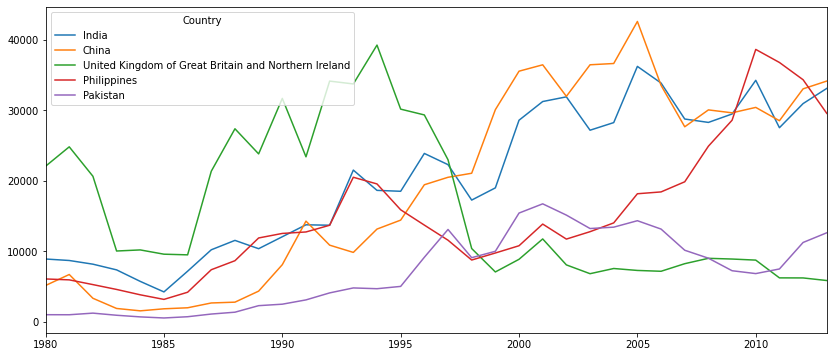

In [93]:
df_can.columns = list(map(str, df_can.columns))
years = list(map(str, range(1980, 2014)))
df_can.sort_values(by='Total',ascending=False, axis=0, inplace=True)
df_can.head()
df_top5=df_can.head(5)
df_top5=df_top5[years].transpose()
df_top5.index=df_top5.index.map(int)
df_top5.plot(kind='line',figsize=(14,6))